# Deploy Stable Diffusion on a Inferentia2 Custom chip with SageMaker and LMI Containers with Neuron compilers

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

---

**In this notebook we will host Stable Diffusion  SageMaker using LMI containers**

In this notebook, we explore how to host a large language model on SageMaker using the [Large Model Inference](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-large-model-inference.html) container that is optimized for hosting large models using DJLServing. DJLServing is a high-performance universal model serving solution powered by the Deep Java Library (DJL) that is programming language agnostic. To learn more about DJL and DJLServing, you can refer to our recent [blog post](https://aws.amazon.com/blogs/machine-learning/achieve-high-performance-with-lowest-cost-for-generative-ai-inference-using-aws-inferentia2-and-aws-trainium-on-amazon-sagemaker/).

The world of artificial intelligence (AI) and machine learning (ML) has been witnessing a paradigm shift with the rise of generative AI models that can create human-like text, images, code, and audio. Compared to classical ML models, generative AI models are significantly bigger and more complex. However, their increasing complexity also comes with high costs for inference and a growing need for powerful compute resources. The high cost of inference for generative AI models can be a barrier to entry for businesses and researchers with limited resources, necessitating the need for more efficient and cost-effective solutions. Furthermore, the majority of generative AI use cases involve human interaction or real-world scenarios, necessitating hardware that can deliver low-latency performance. AWS has been innovating with purpose-built chips to address the growing need for powerful, efficient, and cost-effective compute hardware.


This notebook was tested on a `inf2.8xlarge` instance 


Model license: By using this model, please review and agree to the https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL

### Overview of Inferentia and trn1 instances

Overview of ml.trn1 and ml.inf2 instances
ml.trn1 instances are powered by the Trainium accelerator, which is purpose built mainly for high-performance deep learning training of generative AI models, including LLMs. However, these instances also support inference workloads for models that are even larger than what fits into Inf2. The largest instance size, trn1.32xlarge instances, features 16 Trainium accelerators with 512 GB of accelerator memory in a single instance delivering up to 3.4 petaflops of FP16/BF16 compute power. 16 Trainium accelerators are connected with ultra-high-speed NeuronLinkv2 for streamlined collective communications.

ml.Inf2 instances are powered by the AWS Inferentia2 accelerator, a purpose built accelerator for inference. It delivers three times higher compute performance, up to four times higher throughput, and up to 10 times lower latency compared to first-generation AWS Inferentia. The largest instance size, Inf2.48xlarge, features 12 AWS Inferentia2 accelerators with 384 GB of accelerator memory in a single instance for a combined compute power of 2.3 petaflops for BF16/FP16. It enables you to deploy up to a 175-billion-parameter model in a single instance. Inf2 is the only inference-optimized instance to offer this interconnect, a feature that is only available in more expensive training instances. For ultra-large models that don’t fit into a single accelerator, data flows directly between accelerators with NeuronLink, bypassing the CPU completely. With NeuronLink, Inf2 supports faster distributed inference and improves throughput and latency.

Both AWS Inferentia2 and Trainium accelerators have two NeuronCores-v2, 32 GB HBM memory stacks, and dedicated collective-compute engines, which automatically optimize runtime by overlapping computation and communication when doing multi-accelerator inference. For more details on the architecture, refer to Trainium and Inferentia devices.

For more details refer to [Neuron Docs](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/general/arch/model-architecture-fit.html#diffusion-models)

<img src="images/Neuron-arch.jpeg" width="800"/>





## Create a SageMaker Model for Deployment
As a first step, we'll import the relevant libraries and configure several global variables such as the hosting image that will be used nd the S3 location of our model artifacts

In [ ]:
%pip install -Uq sagemaker

In [ ]:
import sagemaker
from sagemaker.model import Model
from sagemaker import serializers, deserializers
from sagemaker import image_uris
import boto3
import os
import time
import json
import jinja2
from pathlib import Path

In [ ]:
import boto3
import sagemaker
from sagemaker import get_execution_role


import time
from PIL import Image
import numpy as np

# variables
s3_client = None  # boto3.client("s3")
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

### If you are running this notebook from outside of AWS 
Please configure the Appropriate access keys and the Role you would like to assume and ensure the access to that role is there

In [ ]:
import os

# os.environ["AWS_ACCESS_KEY_ID"] = "<your_values>"
# os.environ["AWS_SECRET_ACCESS_KEY"] = "<your_values>"
# os.environ["AWS_DEFAULT_REGION"] = "<your_values>" #"us-east-1"

# os.environ['ASSUME_ROLE'] = "<your_values>"

In [ ]:
role = None
bucket = None
region = None
account_id = None
default_bucket_prefix = None

try:

    role = sagemaker.get_execution_role()  # execution role for the endpoint
    sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
    bucket = sess.default_bucket()  # bucket to house artifacts
    default_bucket_prefix = sess.default_bucket_prefix

    region = sess._region_name  # region name of the current SageMaker Studio environment
    account_id = sess.account_id()  # account_id of the current SageMaker Studio environment
except:
    print("error in sagemaker roles via SDK. Please Configure appropriate values below")
    # - Define the buckets to be used
    role = None
    bucket = "<your_values>"  # bucket to house artifacts
    region = "<your_values>"
    os.environ["ASSUME_ROLE"] = "<your_values>"

# - Define the s3 prefixes

s3_code_prefix = (
    "stablediffusion/neuron/code_sd_g5"  # folder within bucket where code artifact will go
)
# If a default bucket prefix is specified, append it to the s3 path
if default_bucket_prefix:
    s3_code_prefix = f"{default_bucket_prefix}/{s3_code_prefix}"

s3_model_prefix = f"s3://sagemaker-example-files-prod-{region}/models/hf-large-model-djl-ds/neuron/stablediffusion21/"
print(f"public s3:url --- > {s3_model_prefix}::")


jinja_env = jinja2.Environment()  # jinja environment to generate model configuration templates

print(f"Current location to be used for Weights={s3_model_prefix}")
print(f"Current location to be used for Code:prefix={s3_code_prefix}")

#### Use boto3

In [ ]:
assumed_role = os.getenv("ASSUME_ROLE", None)
print(assumed_role)
boto3_kwargs = {}
session = boto3.Session()
if assumed_role:
    sts = session.client("sts")
    response = sts.assume_role(RoleArn=str(assumed_role), RoleSessionName="temp-inf2-llm-1")
    print(f"ROLE:assumed!!!{response}")
    boto3_kwargs = dict(
        aws_access_key_id=response["Credentials"]["AccessKeyId"],
        aws_secret_access_key=response["Credentials"]["SecretAccessKey"],
        aws_session_token=response["Credentials"]["SessionToken"],
    )
    print("Making the role be the Asumed role !!!")
    role = assumed_role

boto3_sm_run_client = boto3.client("sagemaker-runtime", region_name=region, **boto3_kwargs)
# print(boto3_sm_client)

boto3_sm_client = boto3.client("sagemaker", region_name=region, **boto3_kwargs)

boto3_s3_client = boto3.client("s3", region_name=region, **boto3_kwargs)

boto3_iam_client = boto3.client("iam", region_name=region, **boto3_kwargs)

print(f"Role:assumed={role}")
boto3_s3_client

In [ ]:
# - test boto3 works
boto3_s3_client.list_buckets()

### Part 2 - Create the model.tar.gz

This file is the custom inference script for generating images. The model weights have been compiled for specific Hardware as explained below. For convinience the compiled weights will be out in a public S3 location for easy reference. However it is important to note that DJL comes with a pre-built handlers which can be found here [Default handlers](https://github.com/deepjavalibrary/djl-serving/blob/master/engines/python/setup/djl_python/stable_diffusion_inf2.py)

**Model weights**

This notebook leverages the compiled weights for HuggingFace Stable Diffusion 2.1 (512x512) model for accelerated inference on Neuron. For Stable Diffusion 768x768, please see the notebook named [hf_pretrained_sd2_<image_size>_inference](https://github.com/aws-neuron/aws-neuron-samples/tree/master/torch-neuronx/inference)


**Some important points for compiling the model**

Please refer to the model compilation notebooks under [Github](https://github.com/aws-neuron/aws-neuron-samples/tree/master/torch-neuronx/inference) and the files are by the image dimensions for compile parts of the Stable Diffusion pipeline for execution on Neuron. Note that this only needs to be done once: After you have compiled and saved the model by running the following section of code, you can reuse it any number of times without having to recompile. We will Compile the model into an optimized TorchScript and save the TorchScript. In particular, we will compile:
1. The CLIP text encoder;
2. The VAE decoder;
3. The UNet, and
4. The VAE_post_quant_conv
These blocks are chosen because they represent the bulk of the compute in the pipeline, and performance benchmarking has shown that running them on Neuron yields significant performance benefit.

Several points worth noting are:
1. In order to save RAM (these compiles need lots of RAM!), before tracing each model, we make a deepcopy of the part of the pipeline (i.e. the UNet or the VAE decoder) that is to be traced, and then delete the pipeline object from memory with `del pipe`. This trick allows the compile to succeed on instance types with a smaller amount of RAM.
2. When compiling each part of the pipeline, we need to pass `torch_neuronx.trace` sample input(s), When there are multiple inputs, they are passed together as a tuple. For details on how to use `torch_neuronx.trace`, please refer to our documentation here: [Trace Neuron Compilers](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/frameworks/torch/torch-neuronx/api-reference-guide/inference/api-torch-neuronx-trace.html)
3. Note that while compiling the UNet, we make use of the double-wrapper structure defined above. In addition, we also use the optimized `get_attention_scores` function to replace the original `get_attention_scores` function in the `CrossAttention` class.
4. The following section defines some utility classes and functions. In particular, we define a double-wrapper for the UNet and another wrapper for the text encoder. These wrappers enable `torch_neuronx.trace` to trace the wrapped models for compilation with the Neuron compiler. 
5. In addition, the `get_attention_scores` utility function performs optimized attention score calculation and is used to replace the origianl `get_attention_scores` function in the `diffusers` package via a monkey patch 

**Environment for compilations**

Following the Inf2 set up you will find a VENV pre created with the following pip packages installed:
- `torch-neuronx`
- `neuronx-cc`
- `diffusers==0.14.0`
- `transformers==4.26.1`
- `accelerate==0.16.0`

`torch-neuronx` and `neuronx-cc` will be installed when you configure your environment following the Inf2 setup guide. The remaining dependencies can be installed as:

```
diffusers==0.14.0
transformers==4.26.1
accelerate==0.16.0
```

In [ ]:
!rm -rf code_sd
!mkdir -p code_sd
!mkdir -p code_sd/src

In [ ]:
%%writefile code_sd/src/__init__.py
 

There are a few options specified here. Lets go through them in turn<br>
1. `engine` - specifies the engine that will be used for this workload. In this case we'll be hosting a model using the [DJL Python Engine](https://github.com/deepjavalibrary/djl-serving/tree/master/engines/python)
2. `option.entryPoint` - specifies the entrypoint code that will be used to host the model. djl_python.huggingface refers to the `huggingface.py` module from [djl_python repo](https://github.com/deepjavalibrary/djl-serving/tree/master/engines/python/setup/djl_python).  
3. `option.s3url` - specifies the location of the model files. Alternativelly an `option.model_id` option can be used instead to specifiy a model from Hugging Face Hub (e.g. `EleutherAI/gpt-j-6B`) and the model will be automatically downloaded from the Hub. The s3url approach is recommended as it allows you to host the model artifact within your own environment and enables faster deployments by utilizing optimized approach within the DJL inference container to transfer the model from S3 into the hosting instance 
4. `option.task` - This is specific to the `huggingface.py` inference handler and specifies for which task this model will be used
5. `option.tensor_parallel_degree` - Enables layer-wise model partitioning through .
6. `option.load_in_8bit` - Quantizes the model weights to int8 thereby greatly reducing the memory footprint of the model from the initial FP32. See this [blog post](https://huggingface.co/blog/hf-bitsandbytes-integration) from Hugging Face for additional information 

For more information on the available options, please refer to the [SageMaker Large Model Inference Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-large-model-configuration.html)


In [ ]:
%%writefile code_sd/serving.properties
engine = Python
# option.entryPoint=djl_python.transformers-neuronx
# option.entryPoint=djl_python.stable_diffusion_inf2
option.use_stable_diffusion = True
option.model_id = {{s3url}}
option.tensor_parallel_degree = 2
# option.dtype=bf16

In [ ]:
# we plug in the appropriate model location into our `serving.properties` file based on the region in which this notebook is running
template = jinja_env.from_string(Path("code_sd/serving.properties").open().read())
Path("code_sd/serving.properties").open("w").write(template.render(s3url=s3_model_prefix))
!pygmentize code_sd/serving.properties | cat -n

In [ ]:
!aws s3 ls {s3_model_prefix}/compiled_model/

#### Bring your own inference script 
compiled_model/text_encoder.pt does not exist
We will load and replace the following in the base model
In particular, we will load the compiled weights for :
1. The CLIP text encoder;
2. The VAE decoder;
3. The UNet, and
4. The VAE_post_quant_conv

These blocks are chosen because they represent the bulk of the compute in the pipeline. Further we will also load the Replace original cross-attention module with custom cross-attention module for better performance
    CrossAttention.get_attention_scores = get_attention_scores

In [ ]:
%%writefile code_sd/model.py
from io import BytesIO
import traceback
import logging
import math
import os
import torch
import time
import numpy as np

import torch.nn as nn
import torch_neuronx
from djl_python.inputs import Input
from djl_python.outputs import Output
from io import BytesIO
from PIL import Image
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.models.unet_2d_condition import UNet2DConditionOutput
from diffusers.models.cross_attention import CrossAttention

# from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
# from diffusers.models.unet_2d_condition import UNet2DConditionOutput


# - define some clases


class UNetWrap(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        out_tuple = self.unet(sample, timestep, encoder_hidden_states, return_dict=False)
        return out_tuple


class NeuronUNet(nn.Module):
    def __init__(self, unetwrap):
        super().__init__()
        self.unetwrap = unetwrap
        self.config = unetwrap.unet.config
        self.in_channels = unetwrap.unet.in_channels
        self.device = unetwrap.unet.device

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        sample = self.unetwrap(
            sample, timestep.to(sample.dtype).expand((sample.shape[0],)), encoder_hidden_states
        )[0]
        # sample = self.unetwrap(sample, timestep.float().expand((sample.shape[0],)), encoder_hidden_states)[0]
        return UNet2DConditionOutput(sample=sample)


class NeuronTextEncoder(nn.Module):
    def __init__(self, text_encoder):
        super().__init__()
        self.neuron_text_encoder = text_encoder
        self.config = text_encoder.config
        self.dtype = text_encoder.dtype
        self.device = text_encoder.device

    def forward(self, emb, attention_mask=None):
        return [self.neuron_text_encoder(emb)["last_hidden_state"]]


def get_torch_dtype_from_str(dtype: str):
    if dtype == "fp32":
        return torch.float32
    elif dtype == "bf16":
        return torch.bfloat16
    raise ValueError(
        f"Invalid data type: {dtype}. NeuronX currently only supports fp32 and bf16 for stable diffusion"
    )


# Optimized attention
def get_attention_scores(self, query, key, attn_mask):
    dtype = query.dtype

    if self.upcast_attention:
        query = query.float()
        key = key.float()

    # Check for square matmuls
    if query.size() == key.size():
        attention_scores = custom_badbmm(key, query.transpose(-1, -2))

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=1).permute(0, 2, 1)
        attention_probs = attention_probs.to(dtype)

    else:
        attention_scores = custom_badbmm(query, key.transpose(-1, -2))

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = attention_probs.to(dtype)

    return attention_probs


def custom_badbmm(a, b):
    bmm = torch.bmm(a, b)
    scaled = bmm * 0.125
    return scaled


model = None


def load_model(properties):
    model_location = properties["model_dir"]
    if "model_id" in properties:
        model_location = properties["model_id"]
    logging.info(f"Loading model in {model_location}")

    tensor_parallel_degree = int(properties.get("tensor_parallel_degree", 1))
    logging.info(f"Loading model in tensor_parallel_degree= {tensor_parallel_degree}")

    # For saving compiler artifacts

    COMPILER_WORKDIR_ROOT = os.path.join(model_location, "compiled_model")
    logging.info(f"Loading model:COMPILED_model_loc={COMPILER_WORKDIR_ROOT}")

    D_TYPE = get_torch_dtype_from_str(properties.get("dtype", "fp32"))
    DTYPE_ARGS = {"torch_dtype": D_TYPE}
    logging.info(f"Loading model: base model DTYPE={DTYPE_ARGS}:")

    pipe = StableDiffusionPipeline.from_pretrained(model_location, **DTYPE_ARGS)
    # pipe = StableDiffusionPipeline.from_pretrained(model_location, torch_dtype=torch.float32)
    logging.info(f"Loading model: base model loaded")

    # --- Load all compiled models ---
    text_encoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, "text_encoder.pt")
    decoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, "vae_decoder.pt")
    unet_filename = os.path.join(COMPILER_WORKDIR_ROOT, "unet.pt")
    post_quant_conv_filename = os.path.join(COMPILER_WORKDIR_ROOT, "vae_post_quant_conv.pt")

    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

    # Replace original cross-attention module with custom cross-attention module for better performance
    CrossAttention.get_attention_scores = get_attention_scores

    # Load the compiled UNet onto two neuron cores.
    pipe.unet = NeuronUNet(UNetWrap(pipe.unet))
    logging.info(f"Loading model: unet:created")
    device_ids = [idx for idx in range(tensor_parallel_degree)]
    logging.info(f"Loading model in device_ids={device_ids}::")
    pipe.unet.unetwrap = torch_neuronx.DataParallel(
        torch.jit.load(unet_filename), device_ids, set_dynamic_batching=False
    )
    logging.info(f"Loading model: unet:wrap:created")

    # Load other compiled models onto a single neuron core.

    # - load encoders
    pipe.text_encoder = NeuronTextEncoder(pipe.text_encoder)
    try:
        clip_compiled = torch.jit.load(text_encoder_filename)
        pipe.text_encoder.neuron_text_encoder = clip_compiled
        logging.info(f"Loading model: encoders:created")
    except:
        logging.info(
            f"Loading model: NO COMPILED CLIP Encoder file found..  INFERENCING will be SLOWER !!!!!!"
        )
    # - load decoders
    logging.info(f"Loading model: encoders:created")
    pipe.vae.decoder = torch.jit.load(decoder_filename)
    logging.info(f"Loading model: decoders:created")
    pipe.vae.post_quant_conv = torch.jit.load(post_quant_conv_filename)
    logging.info(f"Loading model: vae:post_quant:created")

    logging.info(f"Loading model: All Loaded Model:success")

    return pipe


def run_inference(pipe, prompt, params):
    image = None
    logging.info(f"run_inference: CHANGED:prompt:single={prompt}::params={params}::")

    image = pipe(prompt).images[0]

    logging.info(f"run_inference: image generated!")
    return image


def handle(inputs: Input):
    try:
        global model
        if not model:
            model = load_model(inputs.get_properties())

        if inputs.is_empty():
            return None
        start_time = time.time()

        data = inputs.get_as_json()

        input_sentences = data["prompt"]
        params = data.get("parameters", None)

        img = run_inference(model, input_sentences, params)
        buf = BytesIO()
        img.save(buf, format="PNG")
        byte_img = buf.getvalue()
        outputs = Output().add(byte_img).add_property("content-type", "image/png")

        logging.info(f"handle: :TIME:TAKEN:f{ (time.time() - start_time) * 1000}:ms:::")
    except:
        excep_str = traceback.format_exc()
        logging.info(f"error:in handle():: traceback={excep_str}:")
        outputs = Output().error(excep_str)

    return outputs

In [ ]:
# %%writefile code_sd/requirements.txt
# boto3
# awscli

In [ ]:
!rm -rf `find -type d -name .ipynb_checkpoints`
!rm model.tar.gz
!tar czvf model.tar.gz code_sd

### Upload the Tar file to S3 for Creation of End points

In [ ]:
s3_code_prefix

In [ ]:
s3_resource = boto3.resource("s3", region_name=region, **boto3_kwargs)
if not s3_resource.Bucket(bucket) in s3_resource.buckets.all():
    buck_region = boto3_s3_client.create_bucket(
        Bucket=bucket, CreateBucketConfiguration={"LocationConstraint": region}
    )
    print(f"Bucket created ={buck_region}")

## To create the end point the steps are:

1. Create the TAR ball with just the serving and the model.py files and upload to S3
2. Create the Model using the Image container and the Model Tarball uploaded earlier
3. Create the endpoint config using the following key parameters

    a) Instance Type is ml.inf2.xlarge
    
    b) ContainerStartupHealthCheckTimeoutInSeconds is 240 to ensure health check starts after the model is ready    

    c) VolumeInGB set to a larger value so it can be used for loading the model weights which are 32 GB in size
    
4. Create the end point using the endpoint config create

#### Create the Model
Use the image URI for the DJL container and the s3 location to which the tarball was uploaded.

The container downloads the model into the `/tmp` space on the container because SageMaker maps the `/tmp` to the Amazon Elastic Block Store (Amazon EBS) volume that is mounted when we specify the endpoint creation parameter VolumeSizeInGB. It leverages `s5cmd`(https://github.com/peak/s5cmd) which offers a very fast download speed and hence extremely useful when downloading large models.

For instances like p4dn, which come pre-built with the volume instance, we can continue to leverage the `/tmp` on the container. The size of this mount is large enough to hold the model.


In [ ]:
# - upload_file(Filename, Bucket, Key, ExtraArgs=None, Callback=None, Config=None)

boto3_s3_client.upload_file(
    "./model.tar.gz", bucket, f"{s3_code_prefix}/model.tar.gz"
)  # - "path/to/key.txt"

s3_code_artifact = f"s3://{bucket}/{s3_code_prefix}/model.tar.gz"
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")
boto3_s3_client.list_objects(Bucket=bucket, Prefix=f"{s3_code_prefix}/model.tar.gz").get(
    "Contents", []
)

In [ ]:
print(f"S3 Model Prefix where the model files are -- > {s3_model_prefix}")
print(f"S3 Model Bucket is -- > {bucket}")

### Getting the container image URI

Available framework are:
- djl-deepspeed (0.20.0, 0.21.0, 0.22.1, 0.23.0)
- djl-fastertransformer (0.21.0, 0.22.1, 0.23.0)
- fastertransformer (5.3.0)


In [ ]:
# inference_image_uri = f"{account_id}.dkr.ecr.{region}.amazonaws.com/djl-ds:latest"
inference_image_uri = sagemaker.image_uris.retrieve("djl-neuronx", region=region, version="0.23.0")

print(f"Image going to be used is ---- > {inference_image_uri}")

### Creating end point in SageMaker
<li>First create a Model
<li>Second Create the endpoint config
<li>Third Create the endpoint to host the model

In [ ]:
s3_code_artifact

In [ ]:
from sagemaker.utils import name_from_base

model_name = name_from_base(f"inf2-sd")
print(model_name)

create_model_response = boto3_sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={"Image": inference_image_uri, "ModelDataUrl": s3_code_artifact},
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

In [ ]:
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = boto3_sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.inf2.xlarge",  # -
            "InitialInstanceCount": 1,
            "ContainerStartupHealthCheckTimeoutInSeconds": 360,  # 2400,
            "VolumeSizeInGB": 400,
        },
    ],
)
endpoint_config_response

Create a SageMaker endpoint configuration.

In [ ]:
create_endpoint_response = boto3_sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

### Create the endpoint, and wait for it to be up and running.

#### While you wait for the endpoint to be created, you can read more about:
- [StableDiffusion](https://huggingface.co/spaces/stabilityai/stable-diffusion)
- [Deep Learning containers for large model inference](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-large-model-dlc.html)
- [DeepSpeed](https://www.deepspeed.ai/tutorials/inference-tutorial/#initializing-for-inference)   
- [Quantization in HuggingFace Accelerate](https://huggingface.co/blog/hf-bitsandbytes-integration)
- [Handling big models for inference using Accelerate](https://huggingface.co/docs/accelerate/usage_guides/big_modeling#designing-a-device-map)
   
#### Leverage the Boto3 to invoke the endpoint. 

This is a generative model so we pass in a Text as a prompt and Model will generate the image and return that to us using 50 denoising steps


In [ ]:
resp = boto3_sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = boto3_sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

#### Invoke model

Let's run an example with a basic text generation prompt `Mountains Landscape`

this will create a 512 x 512 resolution picture

In [ ]:
# endpoint_name='inf2-sd-2023-05-12-16-19-36-982-endpoint'

In [ ]:
%%time
import json

response_model = boto3_sm_run_client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=json.dumps({"prompt": "Mountain Landscape", "parameters": {}}),  # "text_length": 128}
    ContentType="application/json",
)

response_model

In [ ]:
resp = response_model["Body"].read()

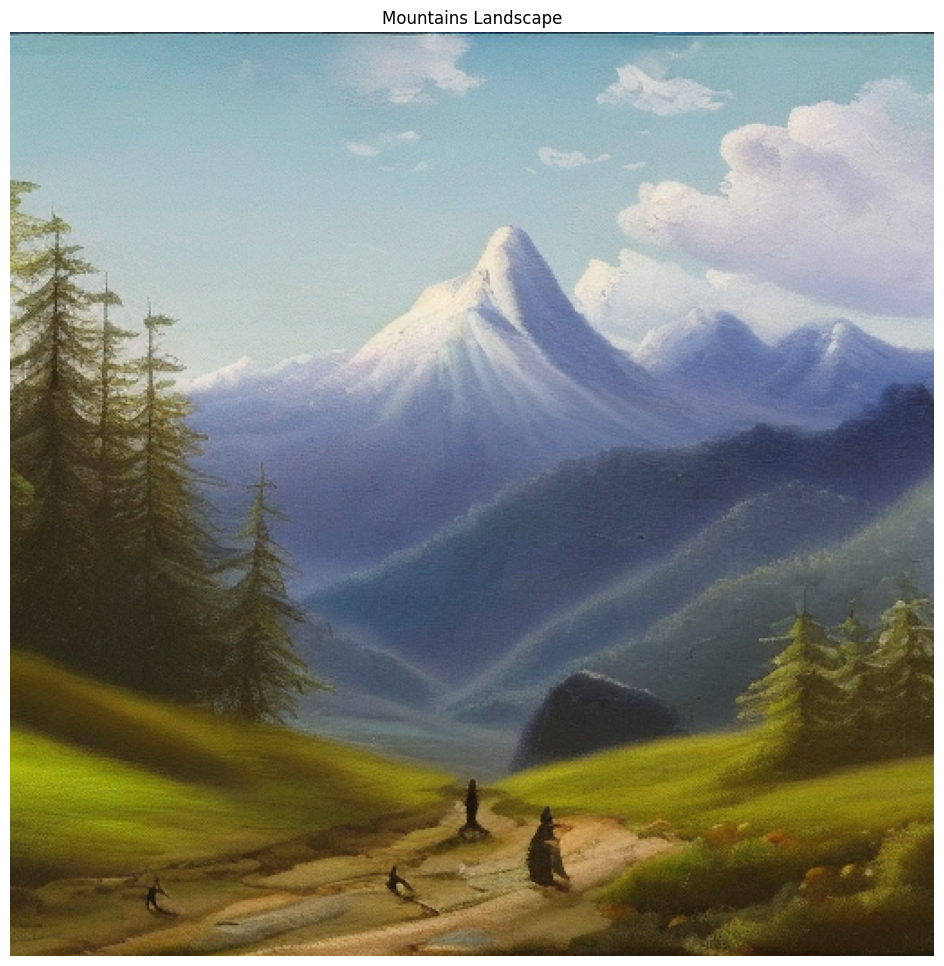

In [27]:
from PIL import Image
import numpy as np
import io
import base64
import matplotlib.pyplot as plt


def decode_image(img):
    buff = io.BytesIO(img)
    image = Image.open(buff)
    return image


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()


display_img_and_prompt(decode_image(resp), "Mountains Landscape")

In [ ]:
# from PIL import Image
# import numpy as np
# import io

# !export DISPLAY=:0.0
# img_res = io.BytesIO(response_model["Body"].read())
# Image.open(img_res).show()

#### P95 numbers

In [ ]:
import numpy as np

results = []
for i in range(0, 10):
    start = time.time()
    prompts = ["Mountains Landscape"]
    response_model = boto3_sm_run_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps({"prompt": "Mountain Landscape", "parameters": {}}),  # "text_length": 128}
        ContentType="application/json",
    )
    results.append((time.time() - start) * 1000)

print("\nPredictions for model latency: \n")
print("\nP95: " + str(np.percentile(results, 95)) + " ms\n")
print("P90: " + str(np.percentile(results, 90)) + " ms\n")
print("Average: " + str(np.average(results)) + " ms\n")

----
----
### Part 8 - Clean up <a name="cleanup"></a>

In [ ]:
boto3_sm_client.delete_endpoint(EndpointName=endpoint_name)
boto3_sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
boto3_sm_client.delete_model(ModelName=model_name)

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option1-aitemplate|lmi-aitemplate-stablediff.ipynb)
